# Logistic Regression Backtester

In [74]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.exceptions import V20Error

class LogRegBacktester():

    def __init__(self, instrument, start, end, granularity, price, tc):
        self.instrument = instrument
        self.start = start
        self.end = end
        self.granularity = granularity
        self.price = price
        self.tc = tc 
        self.model = LogisticRegression(C = 100, max_iter=1000, multi_class='ovr')
        self.results = None

    def __repr__(self):
        rep = 'LogRegBacktester (symbol = {}, start = {}, end = {}, tc = {})'
        return rep.format(self.instrument, self.start, self.end, self.tc)
    
    def get_data(self):
        self.access_token = '65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33'

        client = API(access_token=self.access_token, environment="practice")

        params = {
            "granularity": self.granularity,
            "from": self.start,
            "to": self.end
        }

        # Get the historical pricing data for the EUR/USD pair
        instrument = "EUR_USD"
        r = instruments.InstrumentsCandles(instrument=instrument, params=params)
        try:
            response = client.request(r)
        except V20Error as e:
            print(f"Error: {e}")

        # Parse the response into a Pandas DataFrame
        data = pd.DataFrame(response['candles'])
        data['time'] = pd.to_datetime(data['time'], format="%Y-%m-%dT%H:%M:%S.%f000Z")
        data.set_index('time', inplace=True)
        data.sort_index(inplace=True)

        # Extract only the 'c' values from the 'mid' column
        data['c'] = data['mid'].apply(lambda x: x['c'])
        data.rename(columns={'c': 'price'}, inplace=True)
        data['price'] = pd.to_numeric(data['price'], errors='coerce')
        data.drop(columns=['complete', 'mid', 'volume'], inplace=True)
        data["returns"] = np.log(data['price']/ data['price'].shift(1))
        self.data = data

    def split_data(self, start, end):
        # splits into training and test sets
        # slices/indexs from start to end and returns both sets depending on what's being called when
        data = self.data.loc[start:end].copy()
        return data
    
    def prepare_features(self, start, end):
        self.data_subset = self.split_data(start, end)
        self.feature_columns = []
        for lag in range (1 + self.lags +1):
            col = 'lag{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def fit_model(self, start, end):
        self.prepare_features(start, end)
        self.model.fit(self.data_subset[self.feature_columns], np.sign(self.data_subset['returns']))

    def test_strategy(self, train_ratio = 0.7, lags = 5):
        ''' 
        Backtests the Logistic Regression.
        
        Parameters
        ----------
        train_ratio: float (between 0 and 1.0 excl.)
            Splitting the dataset into training set (train_ratio) and test set (1 - train_ratio).
        lags: int
            number of lags serving as model features.
        '''
        self.lags = lags
                  
        # determining datetime for start, end and split (for training an testing period)
        full_data = self.data.copy()
        split_index = int(len(full_data) * train_ratio)
        split_date = full_data.index[split_index-1]
        train_start = full_data.index[0]
        test_end = full_data.index[-1]
        
        # fit the model on the training set
        self.fit_model(train_start, split_date)
        
        # prepare the test set
        self.prepare_features(split_date, test_end)
                  
        # make predictions on the test set
        predict = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset["pred"] = predict
        
        # calculate Strategy Returns
        self.data_subset["strategy"] = self.data_subset["pred"] * self.data_subset["returns"]
        
        # determine the number of trades in each bar
        self.data_subset["trades"] = self.data_subset["pred"].diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        self.data_subset.strategy = self.data_subset.strategy - self.data_subset.trades * self.tc
        
        # calculate cumulative returns for strategy & buy and hold
        self.data_subset["creturns"] = self.data_subset["returns"].cumsum().apply(np.exp)
        self.data_subset["cstrategy"] = self.data_subset['strategy'].cumsum().apply(np.exp)
        self.results = self.data_subset
        
        perf = self.results["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - self.results["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
        
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "Logistic Regression: {} | Lags = {}".format(self.instrument, self.lags)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def print_performance(self):
        ''' Calculates and prints various Performance Metrics. '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple = round(self.calculate_multiple(data.returns), 6)
        outperf = round(strategy_multiple - bh_multiple, 6)
        cagr = round(self.calculate_cagr(data.strategy), 6)
        ann_mean = round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std = round(self.calculate_annualized_std(data.strategy), 6)
        sharpe = round(self.calculate_sharpe(data.strategy), 6)
        sortino = round(self.calculate_sortino(data.strategy), 6)
        max_drawdown = round(self.calculate_max_drawdown(data.strategy), 6)
        calmar = round(self.calculate_calmar(data.strategy), 6)
        
        print(100 * "=")
        print("LOGISTIC REGRESSION STRATEGY | INSTRUMENT = {} | LAGS = {}".format(self.instrument, self.lags))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print(100 * "=")

    def calculate_multiple(self, series):
        return np.exp(series.sum())

    def calculate_cagr(self, series):
        return np.exp(series.sum()) ** (1 / ((series.index[-1] - series.index[0]).days / 365.25)) - 1

    def calculate_annualized_mean(self, series):
        return series.mean() * 252

    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(252)

    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(252)

    def calculate_sortino(self, series):
        excess_returns = series - 0
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0) ** 2))
        if downside_deviation == 0:
            return np.nan
        else:
            return series.mean() / downside_deviation * np.sqrt(252)

    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns) / cummax
        return drawdown.max()

    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            return cagr / max_dd

    ############################## Parameter Optimization ######################################

    def optimize_parameters(self, lag_range):
        ''' Optimizes the lag parameter for the logistic regression strategy. '''
        best_performance = -np.inf
        best_lag = None
        
        for lag in lag_range:
            performance, _ = self.test_strategy(lags=lag)
            if performance > best_performance:
                best_performance = performance
                best_lag = lag
        
        # Set the best lags found by the optimizer
        self.lags = best_lag
        self.test_strategy(lags=best_lag)  # Test the strategy with the optimal lags
        print(f"Optimal number of lags: {best_lag} | Performance: {best_performance}")
        self.print_performance()
        self.plot_results()

        return best_lag, best_performance


### Instantiating the class

In [86]:
tester = LogRegBacktester('EUR_USD', '2018-01-01', '2023-12-31', 'D', 'A', .0007)

### Getting the data and then printing it

In [87]:
tester.get_data()

In [88]:
tester.data

,price,returns
time,,
2018-01-01 22:00:00,1.20580,NaN
2018-01-02 22:00:00,1.20144,-0.003622
2018-01-03 22:00:00,1.20683,0.004476
2018-01-04 22:00:00,1.20297,-0.003204
2018-01-07 22:00:00,1.19687,-0.005084
...,...,...
2023-12-21 22:00:00,1.10146,0.000218
2023-12-25 22:00:00,1.10420,0.002485
2023-12-26 22:00:00,1.11066,0.005833


### Testing the strategy

In [89]:
tester.test_strategy()

(5.239807, 4.241056)

### Plotting the results
#### creturns = buy and hold

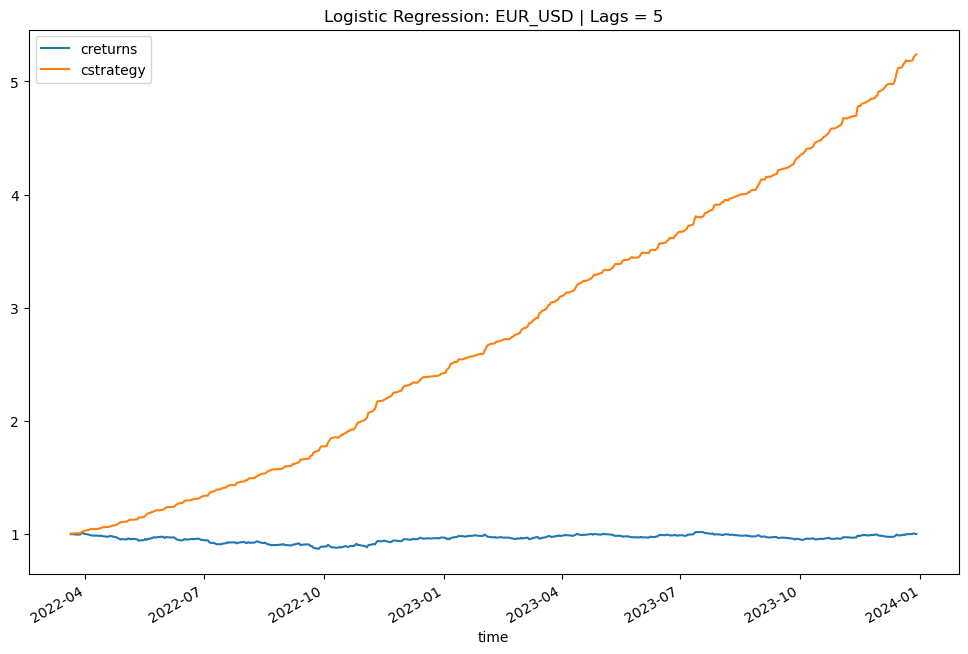

In [90]:
tester.plot_results()

### Printing Results

In [91]:
tester.print_performance()

LOGISTIC REGRESSION STRATEGY | INSTRUMENT = EUR_USD | LAGS = 5
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.239807
Multiple (Buy-and-Hold):     0.998751
--------------------------------------
Out-/Underperformance:       4.241056


CAGR:                        1.543592
Annualized Mean:             0.901477
Annualized Std:              0.058023
Sharpe Ratio:                15.536422
Sortino Ratio:               196.040195
Maximum Drawdown:            0.002919
Calmar Ratio:                528.737709


### Optimizing the lag parameter

Optimal number of lags: 1 | Performance: 5.353384
LOGISTIC REGRESSION STRATEGY | INSTRUMENT = EUR_USD | LAGS = 1
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.353384
Multiple (Buy-and-Hold):     1.008903
--------------------------------------
Out-/Underperformance:       4.344481


CAGR:                        1.552284
Annualized Mean:             0.905327
Annualized Std:              0.057363
Sharpe Ratio:                15.782314
Sortino Ratio:               243.407743
Maximum Drawdown:            0.002168
Calmar Ratio:                715.958756


(1, 5.353384)

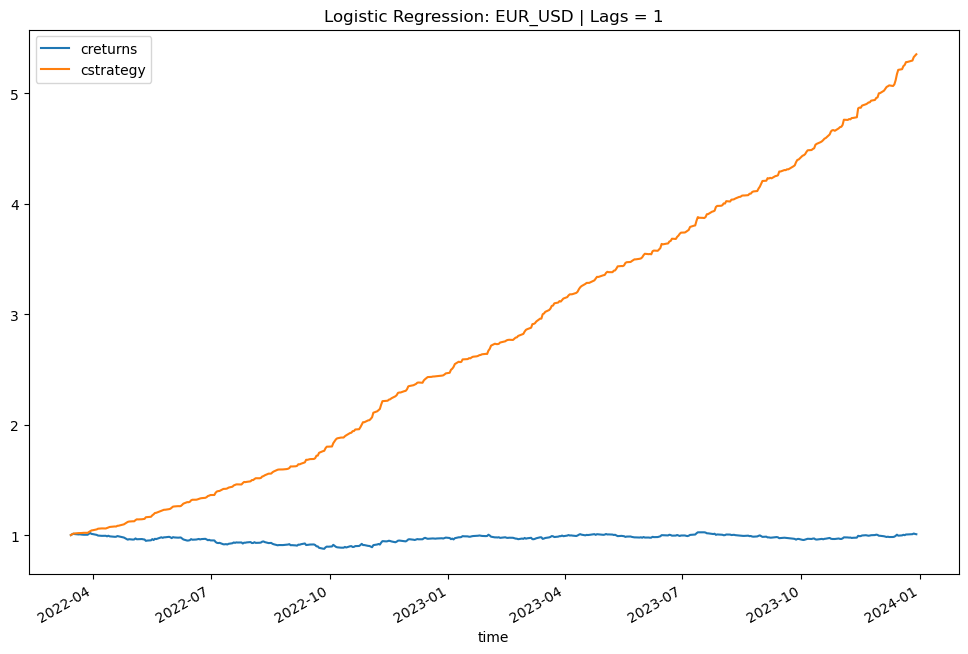

In [95]:
tester.optimize_parameters(lag_range=(1,25))

### Printing out the performance metrics independently

In [96]:
tester.print_performance()

LOGISTIC REGRESSION STRATEGY | INSTRUMENT = EUR_USD | LAGS = 1
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.353384
Multiple (Buy-and-Hold):     1.008903
--------------------------------------
Out-/Underperformance:       4.344481


CAGR:                        1.552284
Annualized Mean:             0.905327
Annualized Std:              0.057363
Sharpe Ratio:                15.782314
Sortino Ratio:               243.407743
Maximum Drawdown:            0.002168
Calmar Ratio:                715.958756


### Plotting the results independently

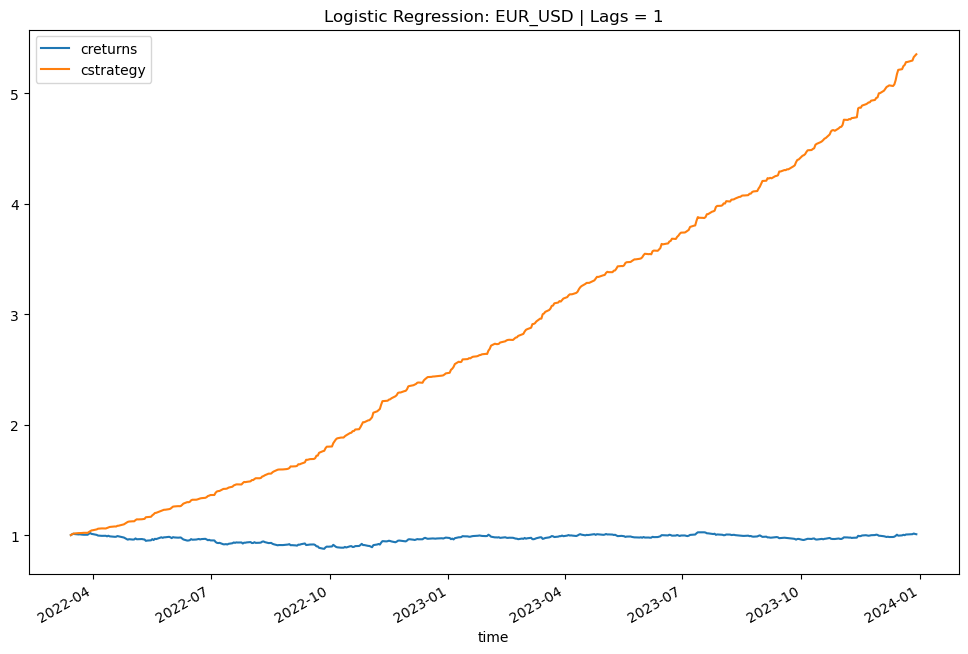

In [97]:
tester.plot_results()